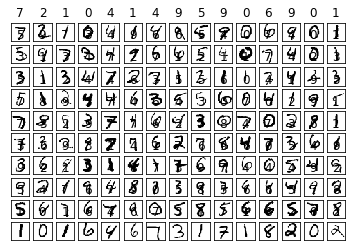

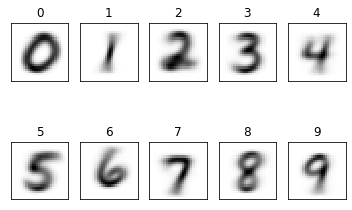

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
file_data   = "/content/drive/My Drive/AssignmentFolder/Assignment09/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

In [4]:
!curl https://colab.chainer.org/install | sh -
#cupy library를 사용하기 위해 사용

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3969      0 --:--:-- --:--:-- --:--:--  3969
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
#X_train : training images
train_data = list_image[0:, 0:6000]
X_train = train_data
#X_test : testing images
test_data = list_image[0:, 6000:10000]
X_test = test_data
#효율적인 값 도출을 위해 random값 고정
np.random.seed(1010)

#np.random.randn : mean = 0, deriviation = 1인 random값
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)
#train
#(784, 1)
X = []
#(196, 1)
Y = []
#(49, 1)
Z = []
#(10, 1)
H = []
#test
#(784,1)
x = []
#(196,1)
y = []
#(49,1)
z = []
#(10,1)
h = []
#bias
bias = 1
#계속 사용하는 function
def sigmoid (z):
    return 1 / (1 + np.exp(-z))
 
def sig_der(z):
    return (z*(1-z))

In [0]:
#구해야 하는 train label
train_label = list_label[0:6000]
real_label = np.zeros((10, 6000))
#label
for i in range(0, 6000):
  for j in range(0, 10):
    if j == train_label[i]:
      real_label[j][i] = 1
    else:
      real_label[j][i] = 0
      
#구해야 하는 test label
test_label = list_label[6000:10000]
test_real_label = np.zeros((10, 4000))
for i in range(0, 4000):
  for j in range(0, 10):
    if j == test_label[i]:
      test_real_label[j][i] = 1
    else:
      test_real_label[j][i] = 0

In [0]:
#use mini batch 

iter = 100
learning_rate = 0.03
train_loss_list = []
test_loss_list = []

#accuracy
train_accuracy_list = []
test_accuracy_list = []
train_correct = 0
test_correct = 0

threshold = 0.000005
#correct / miss list
correct_label = []
correct_image = []
miss_label = []
miss_image = []
#to use convergence append 0
train_loss_list.append(0)
for j in range(iter):
  for i in range(0, 6000):
    #mini_batch
    X = X_train[0:, i:i+1]
    Y = sigmoid(cp.dot(u, X))
    Z = sigmoid(cp.dot(v, Y))
    H = sigmoid(cp.dot(w, Z))

    R = real_label[0:,i:i+1]
    #-값을 가지기도 해서 graph상에 표시할 때는 abs값 적용
    H_loss = H - R
    #to use backpropagation
    #bias는 어차피 1이므로 신경쓰지 않아도 된다
    H_der = H_loss * sig_der(H)
    Z_loss = cp.dot(w.T, H_der)
    Z_der = Z_loss * sig_der(Z)
    Y_loss = cp.dot(v.T, Z_der)
    Y_der = Y_loss * sig_der(Y)

    if i < 4000 :
      #바꿔주기 전 test도 check

      x = X_test[0:, i: (i+1)]
      y = sigmoid(cp.dot(u, x))
      z = sigmoid(cp.dot(v, y))
      h = sigmoid(cp.dot(w, z))
      
      r = test_real_label[0:, i: (i + 1)]
      h_loss = h - r

      if test_real_label[h.argmax()][i] == 1:
        
        test_correct += 1

    tmpw = w - learning_rate * Z.T * H_der
    tmpv = v - learning_rate * Y.T * Z_der
    tmpu = u - learning_rate * X.T * Y_der

    w = tmpw
    v = tmpv
    u = tmpu
      
    if real_label[H.argmax()][i] == 1:
      train_correct += 1
      correct_label.append(H.argmax())
      correct_image.append(X)
    else:
      miss_label.append(H.argmax())
      miss_image.append(X)

  train_loss_list.append(np.mean(np.abs(H_loss)))
  test_loss_list.append(np.mean(np.abs(h_loss)))
  print("iter : ",j)
  if abs(train_loss_list[j] - train_loss_list[j + 1]) < threshold:
    print("converge")
    break
  train_accuracy_list.append(train_correct / 6000)
  test_accuracy_list.append(test_correct / 4000)
  train_correct = 0
  test_correct = 0
#delete 0
del train_loss_list[0]

iter :  0
iter :  1
iter :  2
iter :  3
iter :  4
iter :  5
iter :  6
iter :  7
iter :  8
iter :  9
iter :  10
iter :  11
iter :  12
iter :  13
iter :  14
iter :  15
iter :  16
iter :  17
iter :  18
iter :  19
iter :  20
iter :  21
iter :  22
iter :  23
iter :  24
iter :  25
iter :  26
iter :  27
iter :  28
iter :  29
iter :  30
iter :  31
iter :  32
iter :  33
iter :  34
iter :  35
iter :  36
iter :  37
iter :  38
iter :  39
iter :  40
iter :  41
iter :  42
iter :  43
iter :  44
iter :  45
iter :  46
iter :  47
iter :  48
iter :  49
iter :  50
iter :  51
iter :  52
iter :  53
iter :  54
iter :  55
iter :  56
iter :  57
iter :  58
iter :  59
iter :  60
iter :  61


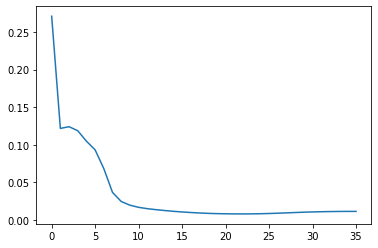

In [341]:
plt.plot(train_loss_list)
plt.show()

In [342]:
print(train_accuracy_list[len(train_accuracy_list) - 1])

0.8566666666666667


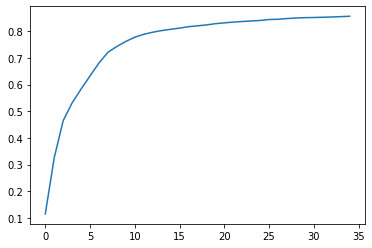

In [327]:
plt.plot(train_accuracy_list)
plt.show()

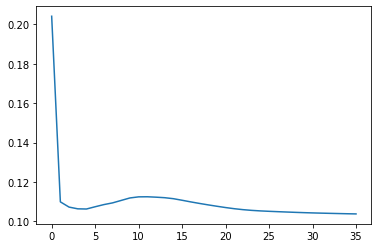

In [328]:
plt.plot(test_loss_list)
plt.show()

In [329]:
print(test_accuracy_list[len(test_accuracy_list) - 1])

0.782


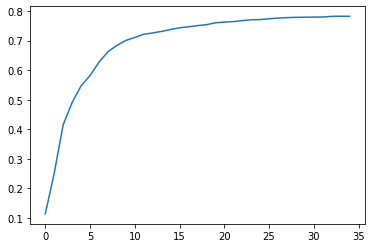

In [330]:
plt.plot(test_accuracy_list)
plt.show()

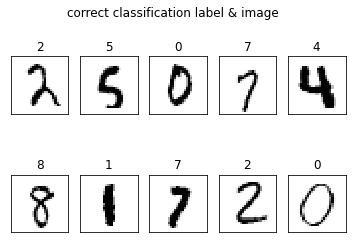

In [331]:
for i in range(10): #correct classification image
  plt.subplot(2, 5,i+1)
  plt.title(correct_label[i+10000])
  plt.imshow(correct_image[i+10000].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.suptitle('correct classification label & image')
plt.show()

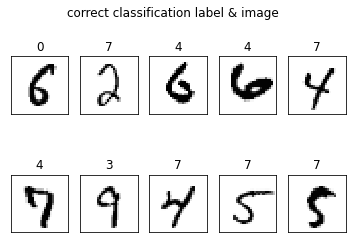

In [332]:
for i in range(10): #correct classification image
  plt.subplot(2,5,i+1)
  plt.title(miss_label[i + 10000])
  plt.imshow(miss_image[i + 10000].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.suptitle('correct classification label & image')
plt.show()

#출력파트

#1. Plot the loss curve

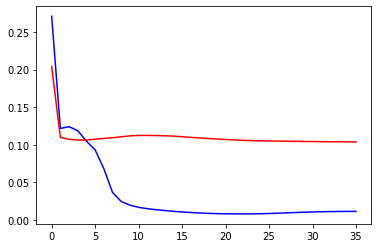

In [333]:
plt.plot(train_loss_list,color ='b')
plt.plot(test_loss_list,color ='r')
plt.show()

#2. Plot the accuracy curve

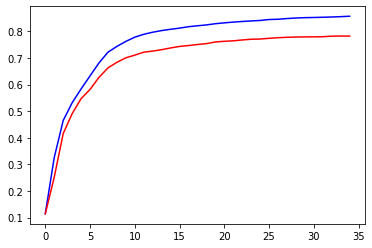

In [334]:
plt.plot(train_accuracy_list,color='b')
plt.plot(test_accuracy_list,color='r')
plt.show()

#3. Plot the accuracy value
(print final accuracy value)

In [335]:
print("Training accuracy : ", train_accuracy_list[len(train_accuracy_list) - 1] * 100 , "%")
print("Testing accuracy : ",test_accuracy_list[len(test_accuracy_list) - 1] * 100, "%")

Training accuracy :  85.66666666666667 %
Testing accuracy :  78.2 %


#4. Plot the classification example
(10 examples)

##Correct classification

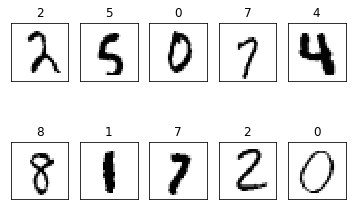

In [336]:
for i in range(10):
  plt.subplot(2, 5,i+1)
  plt.title(correct_label[i+10000])
  plt.imshow(correct_image[i+10000].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.show()

##Miss classification

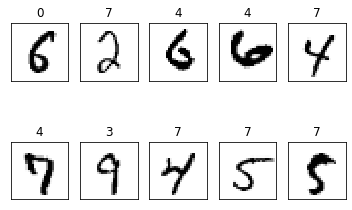

In [337]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.title(miss_label[i + 10000])
  plt.imshow(miss_image[i + 10000].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.show()